In [414]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import os

# read data from new csv file containing cleaned and formatted data
csv_file_path = os.path.join(os.getcwd(), 'new_filtered_data.csv')
data = pd.read_csv(csv_file_path).iloc[::-1]

# add more indicators to help train the model
data['RSI'] = ta.rsi(data['Close'], length=7)
data['EMAF'] = ta.ema(data['Close'], length=14)
data['MACD'] = ta.macd(data['Close'])['MACD_12_26_9']
data['MACDs'] = ta.macd(data['Close'])['MACDs_12_26_9']

# remove columns with NaN values
data.dropna(inplace=True)
print(data.head())

    Exchange Date    Close    Net        RSI         EMAF       MACD  \
302    2023-02-23  1028.76   4.80  29.733511  1047.354304 -12.048748   
301    2023-02-24  1011.73 -17.03  21.379820  1042.604397 -13.828487   
300    2023-02-27  1008.77  -2.96  20.227437  1038.093144 -15.301406   
299    2023-02-28  1004.17  -4.60  18.426688  1033.570058 -16.647978   
298    2023-03-01  1028.69  24.52  47.495107  1032.919384 -15.557253   

         MACDs  
302  -8.731913  
301  -9.751228  
300 -10.861263  
299 -12.018606  
298 -12.726336  


## Process data 

In [415]:
data.drop(['Exchange Date'], axis=1, inplace=True)
print(data.head())

       Close    Net        RSI         EMAF       MACD      MACDs
302  1028.76   4.80  29.733511  1047.354304 -12.048748  -8.731913
301  1011.73 -17.03  21.379820  1042.604397 -13.828487  -9.751228
300  1008.77  -2.96  20.227437  1038.093144 -15.301406 -10.861263
299  1004.17  -4.60  18.426688  1033.570058 -16.647978 -12.018606
298  1028.69  24.52  47.495107  1032.919384 -15.557253 -12.726336


## Scale Data

In [416]:
from sklearn.preprocessing import MinMaxScaler

# Scale data in range 0,1 as it is easier for the model to understand
print(data.head(), end='\n\n')
scaler = MinMaxScaler(feature_range=(0,1))
data_set_scaled = scaler.fit_transform(data)

data_set_scaled = np.array(data_set_scaled)
print(data_set_scaled[:5])

       Close    Net        RSI         EMAF       MACD      MACDs
302  1028.76   4.80  29.733511  1047.354304 -12.048748  -8.731913
301  1011.73 -17.03  21.379820  1042.604397 -13.828487  -9.751228
300  1008.77  -2.96  20.227437  1038.093144 -15.301406 -10.861263
299  1004.17  -4.60  18.426688  1033.570058 -16.647978 -12.018606
298  1028.69  24.52  47.495107  1032.919384 -15.557253 -12.726336

[[0.44115661 0.58255715 0.21658939 0.57022608 0.18935197 0.25956242]
 [0.33660753 0.12044877 0.10417235 0.53494044 0.13359646 0.22411957]
 [0.31843575 0.41828959 0.08866454 0.50142769 0.087453   0.18552224]
 [0.29019584 0.38357324 0.06443156 0.46782704 0.04526771 0.14527998]
 [0.44072687 1.         0.4556102  0.46299337 0.07943784 0.12067134]
 [0.40419915 0.35499577 0.3970398  0.45291076 0.09689385 0.10485937]
 [0.45496961 0.65601185 0.49602783 0.45236388 0.13659293 0.10102229]
 [0.47633372 0.55461473 0.53581038 0.45533683 0.18129584 0.1078759 ]
 [0.44563816 0.37510584 0.47035217 0.45296092 0.208

## Separating data in batches

Here X vector contains 28 values of the last 28 close values, and Y contains the next true 5 day close values. The model will train on the X and Y 

In [417]:
X = []
# how many data points to look behind at before predicting
# 28 because its the average number of days in a month - can be modified
lookback = 28

# go trough every column 
for j in range(len(data_set_scaled[0])):
    X.append([])
    # go trough every data 
    for i in range(lookback, data_set_scaled.shape[0] - 4):
        X[j].append(data_set_scaled[i-lookback:i, j])
        
Y = []
for i in range(lookback, data_set_scaled.shape[0] - 4):
    Y.append(data_set_scaled[i:i+5, 1])

X = np.moveaxis(X, 0, 2)
Y = np.array(Y)
Y = np.reshape(Y, (len(Y), 5))

In [418]:
print(X.shape)
print(Y.shape)

(271, 28, 6)
(271, 5)


## Split data into train test sets

We chose to go with a 80% train and 20% split

In [419]:
split = int(len(X) * 0.8)
X_train , X_test = X[:split], X[split:]
Y_train , Y_test = Y[:split], Y[split:]

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(216, 28, 6)
(55, 28, 6)
(216, 5)
(55, 5)


## LSTM Model

In [420]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(tf.config.list_physical_devices('CPU'))
print(keras.__version__)

2.16.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
3.3.3


In [421]:
from keras.src.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

# the first input layer of the same size as the vectors in X
lstm_input = Input(shape=(lookback, len(data_set_scaled[0])), name='lstm_input')
# first hidden layer of 50 units
inputs = LSTM(50, name='first_layer', return_sequences=True)(lstm_input)
# second hidden layer of 50 units
inputs = LSTM(50, name='second_layer', return_sequences=False)(inputs)
# first layer to squish data in new dimension
inputs = Dense(25, name='third_layer')(inputs)
# second layer to squish data to output format
inputs = Dense(5, name='dense_layer')(inputs)
# activation funciton used: Tanh
output = Activation(keras.activations.tanh, name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
# added Adam optimizer for the model
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
# model.fit(x=X_train, y=Y_train, batch_size=32, epochs=10, shuffle=True, validation_split=0.1)
model.fit(x=X, y=Y, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.2118 - val_loss: 0.0381
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0436 - val_loss: 0.0875
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0442 - val_loss: 0.0354
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0331 - val_loss: 0.0342
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0318 - val_loss: 0.0392
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0302 - val_loss: 0.0400
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0313 - val_loss: 0.0335
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0279 - val_loss: 0.0330
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0294 - val_loss: 0.0362
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0280 - val_loss: 0.0342


## Overall RMSE 

This cell is used for calculating RMSE on train/test data sets

In [422]:
from sklearn.metrics import root_mean_squared_error

prediction_batch = model.predict(X_test)
rmse = root_mean_squared_error(Y_test, prediction_batch)

print(rmse)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
0.16211152755372138


## Last 5 Days Prediction

This block retrieves the next 5 days from our last data point

In [424]:
test = np.array([X[-1]]) 
prediction = model.predict(test)

print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[0.53653294 0.50796014 0.49534905 0.5424767  0.58413434]]


Here we scale out data back up to a more human understandable format (the original format)

In [425]:
# prediction = [[0.98643256, 1., 0.98103014, 0.90066916, 0.82804346]]
scaled_prediction = scaler.inverse_transform([[test[-1][-1][0], prediction[0][0], 0, 0, 0, 0],
                          [0, prediction[0][1], 0, 0, 0, 0],
                          [0, prediction[0][2], 0, 0, 0, 0],
                          [0, prediction[0][3], 0, 0, 0, 0],
                          [0, prediction[0][4], 0, 0, 0, 0]])

last_predicted = scaled_prediction[0][0]
prediction_set = []
for i in range(5):
    prediction_set.append(last_predicted + scaled_prediction[i][1])
    last_predicted = prediction_set[-1]

print(prediction)
print(prediction_set)

[[0.53653294 0.50796014 0.49534905 0.5424767  0.58413434]]
[1094.4058160138131, 1095.6818530607225, 1096.3621421623232, 1099.2687421154978, 1104.1432483506205]


Plot of the test data (the actual correct 5 days) - red vs our prediction - green.
And calculation of RMSE

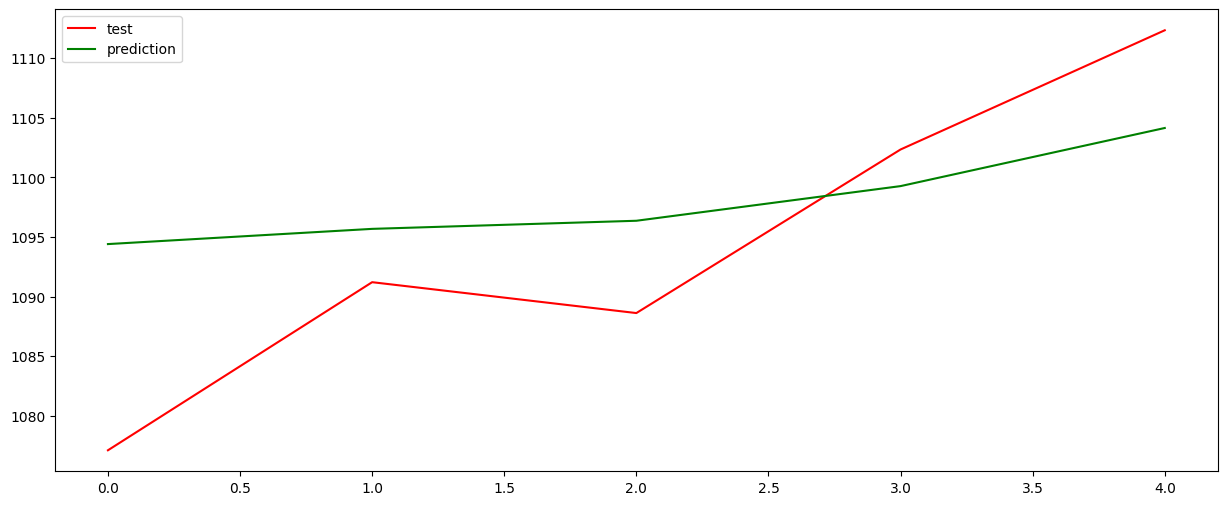

8.155564154148077


In [426]:
plt.figure(figsize=(15,6))
test_set = [1112.34, 1102.34, 1088.62, 1091.21, 1077.11][::-1]

plt.plot(test_set, color='red', label='test')
plt.plot(prediction_set, color='green', label='prediction')
plt.legend()
plt.show()

print(root_mean_squared_error([prediction_set], [test_set]))